In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import IPython.display as ipd
from IPython.display import Audio
import librosa
from librosa import display
import librosa.display
from iteration_utilities import deepflatten #flatten nested lists
from fractions import Fraction
import pretty_midi
import fluidsynth
#import soundfile as sf
from music21 import *
import itertools
import random
import mchmm #for Markov models

#conda install -c conda-forge sox
import pysndfx #sound processing
import nltk #for NLP

Install MuseScore

# Intro to Music21

Full documentation: http://web.mit.edu/music21/

## Data structure

The main musical object we will work with in music21 is note.Note. Each note.Note object, unsurprisingly, represents... one note!

In [2]:
n = note.Note()

There are four main containers (streams) of musical objects in music21: 
- stream.Measure, which is meant to contain a segment of music with no internal subdivision (e.g., no barlines)
- stream.Stream and stream.Part, which are meant to gather several adjacent measures (e.g., an individual instrument in a score) 
- stream.Score, which is meant to gather several simultaneous streams (e.g., the whole score)

The different types of stream can be organised hierarchically: a stream.Stream may contain two simultaneous stream.Parts, each comprising several adjacent stream.Measures. 

For example, let us have a look at this chorale by J. S. Bach, drawn from musci21 corpora:

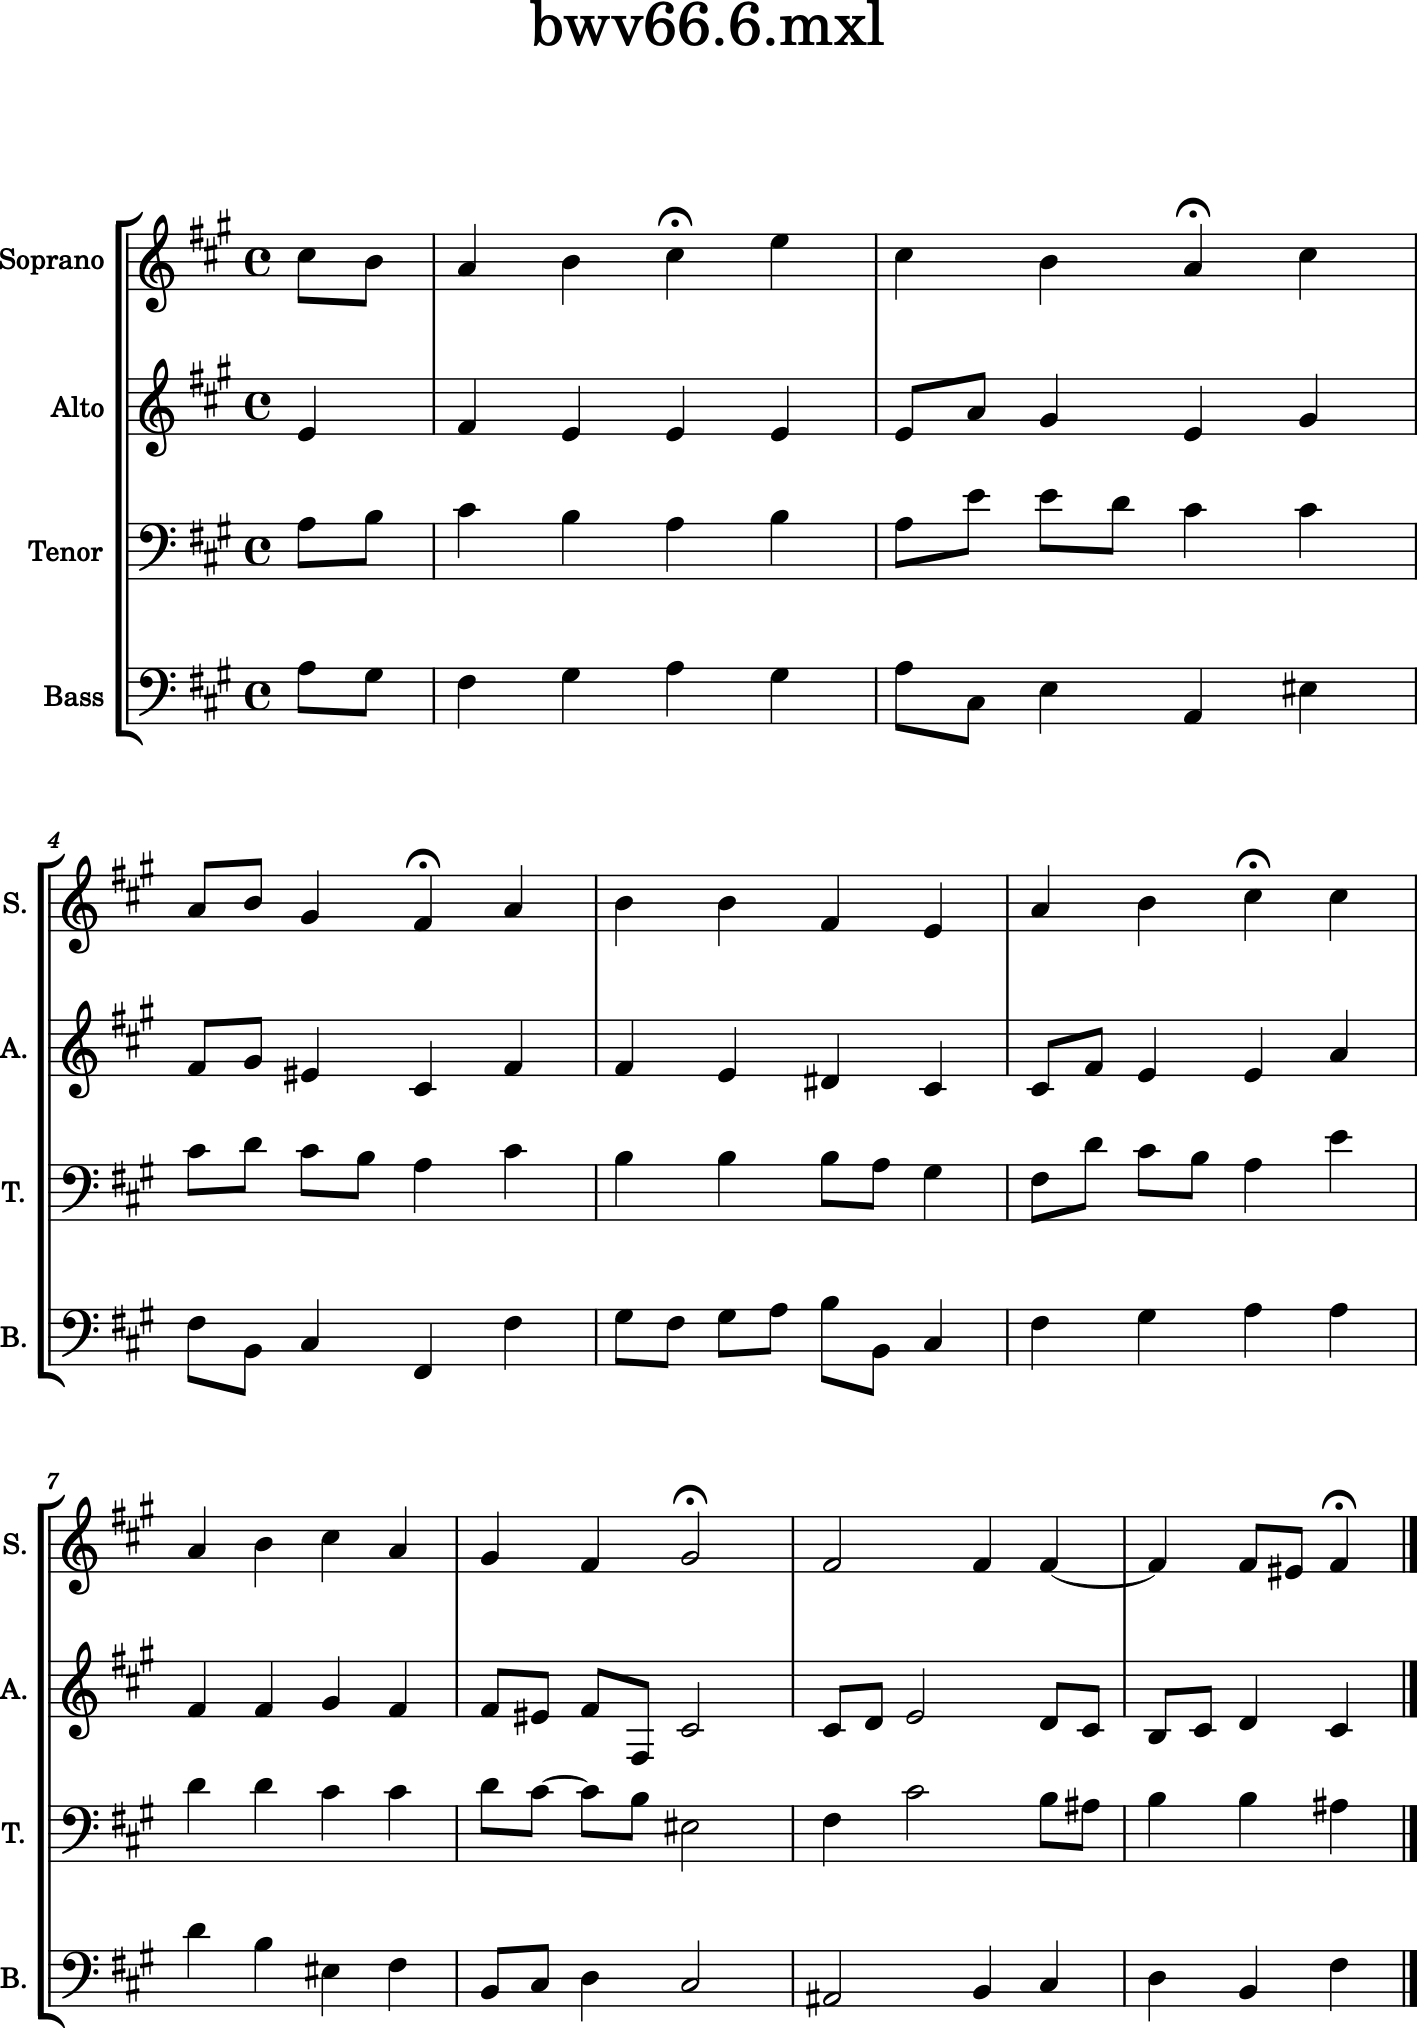

In [3]:
bach_chorale = corpus.parse('bwv66.6')
bach_chorale.show()

The bach_chorale variable now stores a stream.Score object:

In [4]:
bach_chorale

<music21.stream.Score 0x7f9235710410>

and, if we look into the full data structure, we see how note.Note objects are embedded into stream.Measure objects, which are nested into stream.Part objects (one for Soprano, one for Alto, ecc), which collectively form the stream.Score: 

In [5]:
bach_chorale.show('text')

{0.0} <music21.metadata.Metadata object at 0x7f92356fd7d0>
{0.0} <music21.stream.Part Soprano>
    {0.0} <music21.instrument.Instrument 'P1: Soprano: Instrument 1'>
    {0.0} <music21.stream.Measure 0 offset=0.0>
        {0.0} <music21.clef.TrebleClef>
        {0.0} <music21.key.Key of f# minor>
        {0.0} <music21.meter.TimeSignature 4/4>
        {0.0} <music21.note.Note C#>
        {0.5} <music21.note.Note B>
    {1.0} <music21.stream.Measure 1 offset=1.0>
        {0.0} <music21.note.Note A>
        {1.0} <music21.note.Note B>
        {2.0} <music21.note.Note C#>
        {3.0} <music21.note.Note E>
    {5.0} <music21.stream.Measure 2 offset=5.0>
        {0.0} <music21.note.Note C#>
        {1.0} <music21.note.Note B>
        {2.0} <music21.note.Note A>
        {3.0} <music21.note.Note C#>
    {9.0} <music21.stream.Measure 3 offset=9.0>
        {0.0} <music21.layout.SystemLayout>
        {0.0} <music21.note.Note A>
        {0.5} <music21.note.Note B>
        {1.0} <music21.note.Not

## Playback

In order to play the sound of note objects, let us embed them into a stream object:

In [6]:
m = stream.Measure() #create stream.Measure
m.append(n) #embed note in Measure

and then

In [7]:
def play(score):
    #Shortcut to play a stream
    midi.realtime.StreamPlayer(score).play()

In [8]:
play(m)

pygame 2.0.0 (SDL 2.0.12, python 3.7.4)
Hello from the pygame community. https://www.pygame.org/contribute.html


Each note has two main attributes: its pitch and its duration. 

By default, the pitch of note.Note is a "middle C", i.e., the C in the middle octave of a piano keyboard. Its duration, by default, is a quarter-note.

We can see it in score representation:

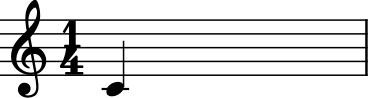

In [9]:
note.Note().show()

Clearly, it is possible to manipulate both the pitch and the duration of a note.Note object.

## Pitch

There are several ways to represent and refer to the pitch of a note.

#### Pitch class and octave
Western musicians typically refer to the twelve chromatic pitches by their name: C, C#\Db, D, D#\Eb, ...

However, note that the name of a note is not sufficient to uniquely identify its pitch. In fact, we have one C, one C#\Db, etc. for each octave. As a consequence, we may identify the pitch of a note by specifying its name (or pitch class) and its octave.

For example, the pitch class of the default Note object is

In [10]:
note.Note().pitch.name

'C'

and its octave is

In [11]:
note.Note().pitch.octave

4

Let us now define a new Note object, corresponding to the C# right above the middle C:

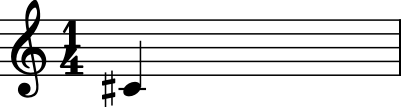

In [12]:
Csharp = note.Note(pitch = 'C#', octave = 4)
Csharp.show()

or

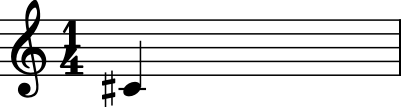

In [13]:
CsharpALT = note.Note(pitch = 'C#4')
CsharpALT.show()

In [14]:
#Are Csharp and CsharpALT the same note?
Csharp == CsharpALT

True

#### MIDI pitch
Alternatively, we may map each key of the piano keyboard onto an integer. This representation, the MIDI pitch, is conventionally defined so that "middle C" has value 60, and all other values are determined accordingly. As a consequence, the default MIDI pitch of a note.Note object is...

In [15]:
note.Note().pitch.midi

60

Let us now create a new note object representing a note with pitch class E, but one octave higher than middle C. Pitch class E is 4 halfsteps above pitch class C (C --> C# --> D --> D# -->E), and we further need to move one octave higher, which is 12 more halfsteps:

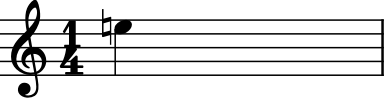

In [16]:
highE = note.Note(pitch = 60 + 4 + 12)
highE.show()

We can listen to both our Csharp and our highE, one after the other:

In [17]:
melodic_interval = stream.Measure()
melodic_interval.append([Csharp, highE])
play(melodic_interval)

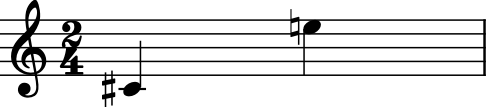

In [18]:
melodic_interval.show()

If we want to hear them simultaneously, we can create a chord object:

In [19]:
c = chord.Chord([Csharp, highE])
harmonic_interval = stream.Measure()
harmonic_interval.append(c)
play(harmonic_interval)

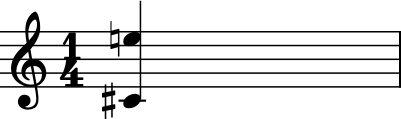

In [20]:
harmonic_interval.show()

#### Absolute frequency

While picking from the chromatic scale is the default for many genres in the Western historical tradition, this is by no means the only option (more on this in Week 4). In particular, we can also specify the pitch of a note by its absolute frequency in Hz:

In [21]:
n1 = note.Note(name = 'A4')

## Create a new note object and reassign its pitch in terms of an absolute frequency
n2 = note.Note()
n2.pitch.frequency = 450 #Hz

## Create a new note object and reassign its pitch in terms of an absolute frequency
n3 = note.Note()
n3.pitch.frequency = 460 #Hz

n4 = note.Note(name = 'A#4')

m = stream.Measure()
m.append([n1, n2, n3, n4])


play(m)

Note that, if you choose arbitrary frequencies, the score is not an appropriate representation anymore. The score representation is tailored to encode Western (mainly tonal) music, and does not afford appropriate notation for micro-tonal pitches, i.e., pitches that fall in-between the twelve chromatic tones. If you try, you will get an approximation to the closest quarter-tone, which is as far as ordinary Western notation gets. In particular, observe how the last two tones are *notated* as being the same pitch, yet they *sound* different.

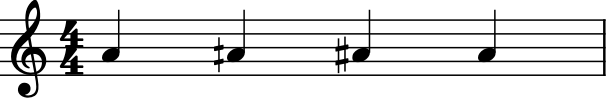

In [22]:
m.show()

#### Microtonal tuning

One way to work with microtonal pitches is to interpret them as deformations of the familiar chromatic pitches. For example, let us look again at J. S. Bach's chorale:

In [204]:
bach_chorale = corpus.parse('bwv66.6')
play(bach_chorale)

We can imagine to play this chorale on a de-tuned keyboard. Specifically, let us de-tune each of the 128 "keys" of the midi-pitched keyboard by a random value comprised betweeen -50 and +50 cents (1 cent is 1/100 of a semitone): 

In [24]:
keyDetune = []
for i in range(127):
    keyDetune.append(random.randint(-50, 50))

Now, we apply the randomly determined mistuning to the original chorale, and play the result:

In [205]:
for n in bach_chorale.flat.notes:
    n.pitch.microtone = keyDetune[n.pitch.midi] #apply the microtonal tuning to each note in the piece
sp = midi.realtime.StreamPlayer(bach_chorale)
sp.play()

However, considering microtonal pitches as deformation of chromatic pitches is just one option. Pitch-space is a continuous interval of positive real numbers, spanning the whole range of audible frequencies (~20Hz - ~20000Hz) and you can and should explore creative ways to filter and organise this space!

## Duration

In music21, durations are expressed relative to a "musical" measurement unit, which is the quarterLength, i.e., the duration of a quarter note. The quarter note is itself 1/4 of a whole note, and other typical duration values in Western notation can be obtained by dividing and multiplying by powers of 2.

From left to right, a 64th note, a 32th note, a 16th note, an eigth note, a quarter note, a half note, a whole note, and a brevis (2 x whole note) 

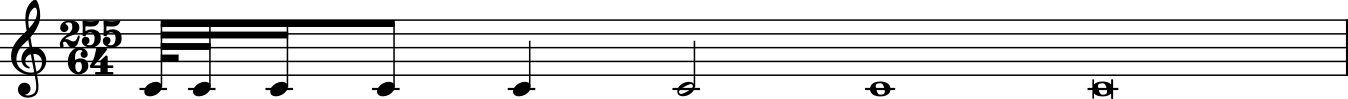

In [26]:
m = stream.Measure()
for i in range(-4, 4):
    m.append(note.Note(quarterLength = 2 ** i))
m.show()    

and the corresponding rests (i.e., silences)

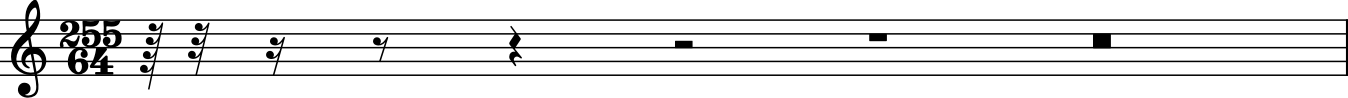

In [27]:
m = stream.Measure()
for i in range(-4, 4):
    m.append(note.Rest(quarterLength = 2 ** i))
m.show()  

It is also possible to have ternary (or n-ary) splits of these basic durations:

In [30]:
s = stream.Stream()

unit = 1 #unit to be split
mUnit = stream.Measure(0)
mUnit.append(note.Note(quarterLength = unit))


N = 3 #N-ary split
mTuplet = stream.Measure(1)
for i in range(N):
    mTuplet.append(note.Note(quarterLength = unit/N))

s.append([mUnit, mTuplet])

play(s)

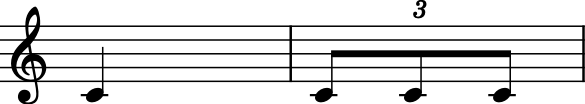

In [28]:
s.show()

In [31]:
mUnit.quarterLength == mTuplet.quarterLength

True

Clearly, it is also possible to assign completely arbitrary durations!

In [206]:
dur = [np.sqrt(5), np.pi, 11/13]

m = stream.Measure()
m.append([note.Note(quarterLength = x) for x in dur])

play(m)

Do not expect to be able to show this measure in score notation! (try, if you dare)

In [33]:
#m.show()

Nevertheless, you can still choose a piano-roll representation:

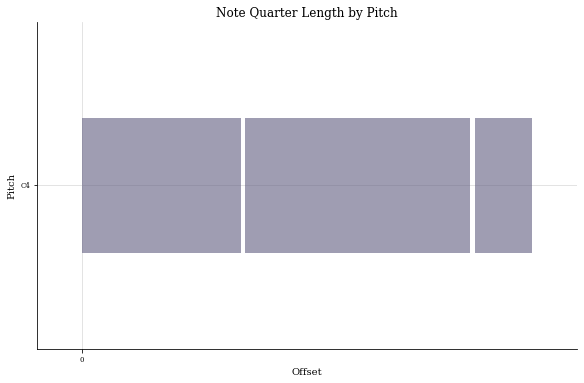

In [34]:
m.plot()

#### Tempo

To set the *actual* duration of a note in seconds, we also need to specify the **tempo** (the speed), which is expressed in beats per second (bps). The default tempo is 120bps (i.e., two quarter notes per second). At 60bps, the quarterLength unit corresponds to seconds.

In [35]:
m = stream.Measure()
m.append(tempo.MetronomeMark(number = 60)) #Set the tempo at 60bps

for i in range(4): #                           
    m.append(note.Note(quarterLength = 1))
    
play(m)

#### Meter

In Western notation the duration of a measure, the meter, is typically specified at the outset. If you set the Time Signature in a stream.Stream() object, measure splits will be added automatically.

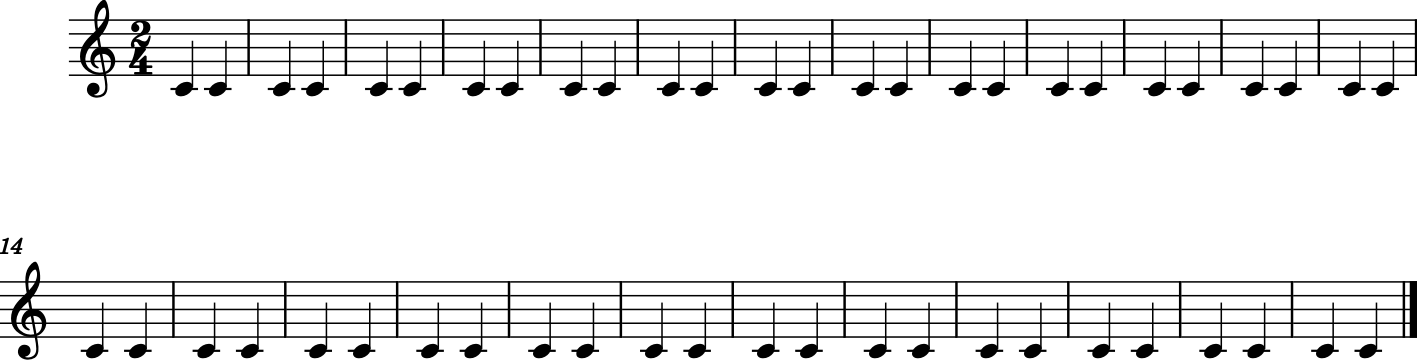

In [36]:
s = stream.Stream()
s.append(meter.TimeSignature('2/4'))

for i in range(50): #                           
    s.append(note.Note(quarterLength = 1))
    
s.show()

Otherwise, you can build a stream object by assembling several measures...

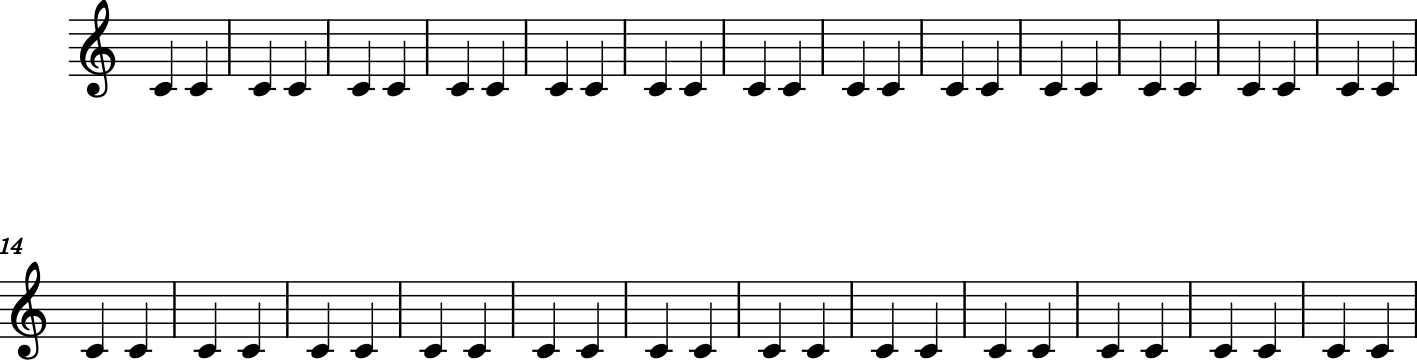

In [223]:
s = stream.Stream()

for i in range(25):
    m = stream.Measure(i)
    m.append([note.Note(), note.Note()])
    s.append(m)
    
s.show()

... not necessarily with the same meter:

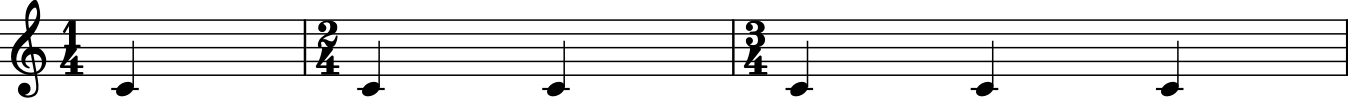

In [230]:
s = stream.Stream()

for i in range(1,4):
    m = stream.Measure(i)
    m.append(meter.TimeSignature(str(i)+'/4'))
    m.append([note.Note() for k in range(i)])
    s.append(m)
    
s.show()

# An example

Pitch material is drawn from three *motto*s: 
- J. S. Bach's musical signature (Bb, A, C, B, or BACH in german notation).
- R. Schumann's *sphinx* from the Carnaval op. 9, ASCH https://en.wikipedia.org/wiki/Carnaval_(Schumann). 
- The motto *Frei aber einsam*, from Schumann's, Brahms' and Dietrich's collaborative violin sonata FAE https://en.wikipedia.org/wiki/F-A-E_Sonata.

These three short motives, inspired by meaningful words, have been used as seeds for entire compositions or segments thereof. Here, we use them as the basis for an algorithmic approach. 

What is going on in this "piece"?

In [251]:
BACH = ['Bb4', 'A4', 'C5', 'B4']
ASCH = ['A4', 'Eb4', 'C5', 'B4'] 
FAE = ['F4', 'A4', 'E4'] 

mottos = [BACH, ASCH, FAE]


durations = [1, 1.5, 0.5, 0.5, 0.5] 

n_bars_per_motto = 3

bps = 200
timeSig = '4/4'
s = stream.Stream()
s.append(tempo.MetronomeMark(number = bps)) 
s.append(meter.TimeSignature(timeSig)) 

measure_count = 0 
while not np.product([len(set(x)) == 1 for x in mottos]):
    for motto_index in range(len(mottos)):
        for bar in range(n_bars_per_motto):
            m = stream.Measure(measure_count)

            random.shuffle(durations)
    
            selected_notes = [note.Note(pitch = random.choice(mottos[motto_index]), quarterLength = dur) for dur in durations]
            m.append(selected_notes)
    
            s.append(m)
        
            measure_count += 1
            
        mottos[motto_index] = list(s[-n_bars_per_motto:].flat.pitches) 

Here is the output in three different representations: score, audio, and piano roll.

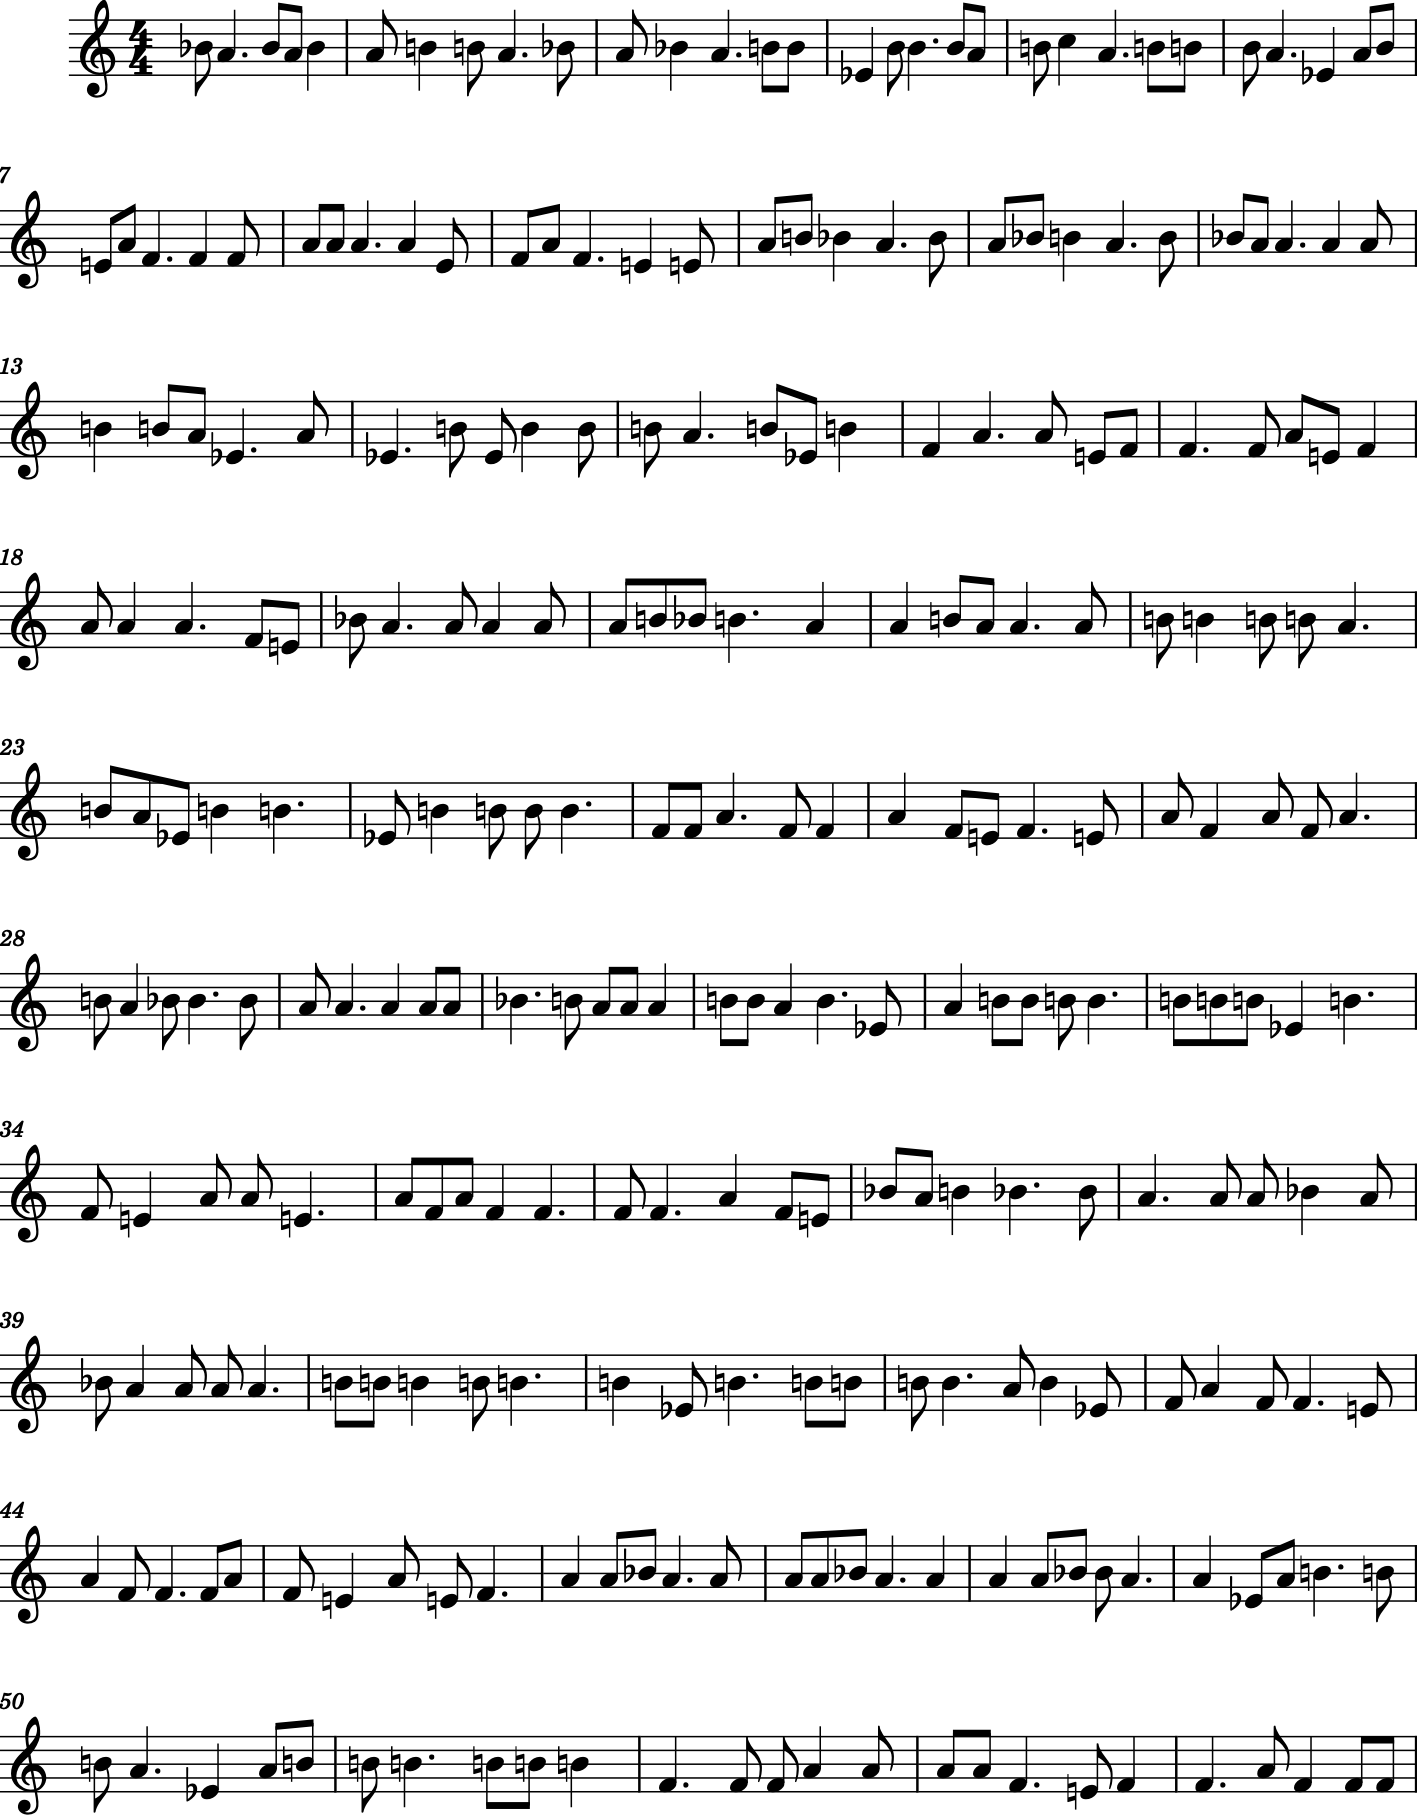

In [252]:
s.show()

In [253]:
overall_duration = float(measure_count*4*Fraction(timeSig)/bps)
print(f'Before uncommenting the following line to listen to the audio, please note that this rendition lasts {overall_duration} minutes.')

Before uncommenting the following line to listen to the audio, please note that this rendition lasts 5.22 minutes.


In [244]:
#play(s)

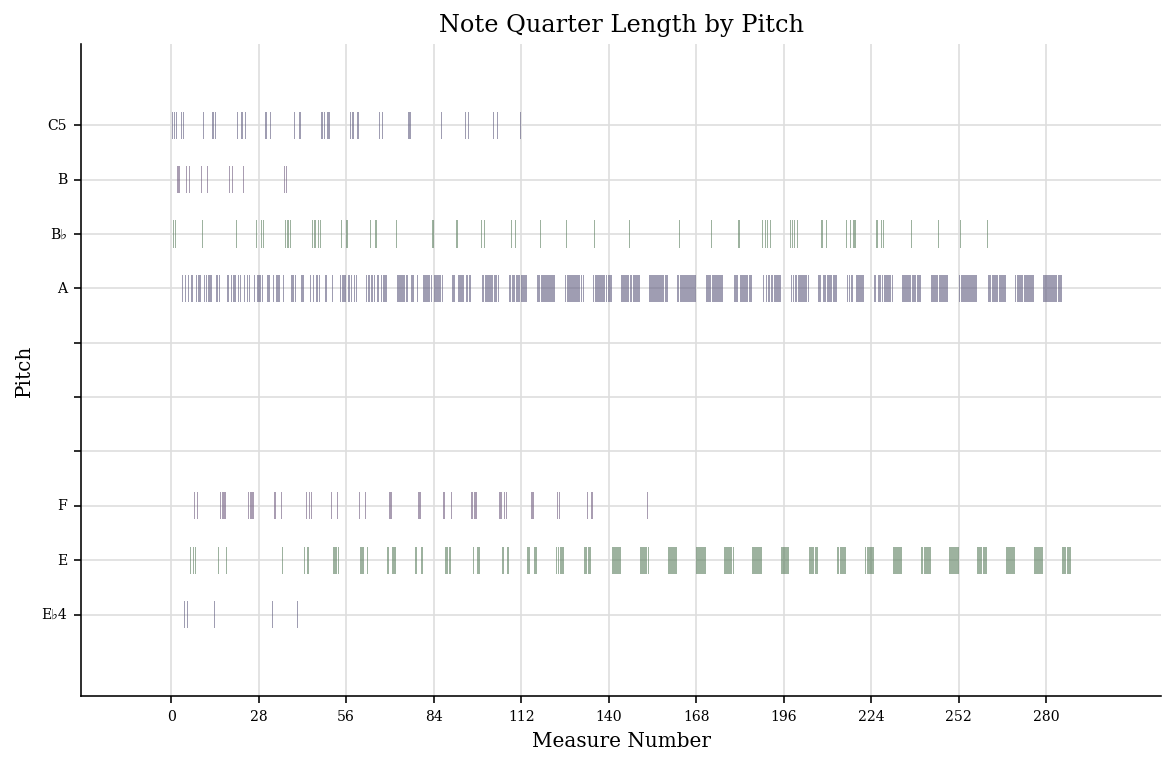

In [198]:
s.plot()

# Exercise: Mozart's Würfelspiel

Implement a reduced version of Mozart's Würfelspiel, using a coin toss instead of a dice roll (i.e., only two options for each bar). 

You find the original score here:

https://ks4.imslp.net/files/imglnks/usimg/b/bc/IMSLP20432-PMLP47543-mozart_-_dice_waltz.pdf